In [ ]:
import numpy as np
import pandas as pd
import os
import sys

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the project root to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

from src.datasets import ASRDataset
from utils.asr import test_model, transcribe_and_get_formats
from utils.text_processing import get_corrected_text, replace_digits_with_words, replace_digits_with_words_groq, replace_digits_with_words_fireworks
from utils.validation import get_wer, visualize_wer, analyze_wer_breakdown, print_metrics, plot_overall_wer_distribution, plot_per_language_wer_distributions
from utils.summarise_benchmark import summarize_results, create_dashboard

In [2]:
from decouple import config
AZURE_API_KEY = config("AZURE_API_KEY")
AZURE_API_REGION = config("AZURE_API_REGION")
OPENAI_API_KEY = config("OPENAI_API_KEY")
OPENAI_GROQ_API_KEY  = config("OPENAI_GROQ_API_KEY")
FIREWORKS_API_KEY = config("FIREWORKS_API_KEY")

In [3]:
SOURCE_SCV = os.path.join("..", "dataset", "sources.csv")
TRANSCRIPT_DIR = os.path.join("..", "dataset", "transcripts")
AUDIO_DIR      = os.path.join("..", "dataset", "audio")

In [4]:
sources_df = pd.read_csv(SOURCE_SCV)

In [5]:
sources_df.head(3)

,url,lang,yt_lang_code,start_time,end_time,file_name,id,description
0,https://www.youtube.com/watch?v=wb6lWvwZin8,lv,lv,00:52:11,00:53:03,lv_1,lv_wb6lWvwZin8_0-52-11.0-0-53-03.0,"Short fragment from the poem ""Lāčplēsis"""
1,https://www.youtube.com/watch?v=IH3AZzxdifA,lv,lv,00:00:30,00:00:54,lv_2,lv_IH3AZzxdifA_0-0-29.8-0-0-54.0,What is hate speech? (Latvian)
2,https://www.youtube.com/watch?v=NUhP-UQ35h8,lv,lv,00:00:27,00:00:48,lv_3,lv_NUhP-UQ35h8_0-0-27.0-0-0-48.0,Ezītis kosmosā


In [6]:
dataset = ASRDataset(sources_df, AUDIO_DIR, TRANSCRIPT_DIR)

In [7]:
len(dataset)

25

In [7]:
sample = dataset[5]

print(sample["transcript"])
print(f"\nSample audio path: {sample["audio_path"]}")

Once there was a bird who fell in love with a whale.
And a whale who fell in love with a bird.
The bird loved the whale's beautiful smile.
He loved the way she swam through the water so gracefully.
The whale loved the bird's handsome white feathers.
She loved to watch him soar through the sky.
And they both loved to eat lots of tiny fish.


Sample audio path: dataset\audio\en_1.wav


Jautājumi:
- Kā labāk wrappot datasetu priekš ASR testēšanas
- Metrics priekš testēšanas? Word error rate? Chracter error rate?
    - Accuracy + latency + cost

To do:
- File names
    - en1
    - en2
- Dokumentācija
- APIs - kādi jautājumi?
- Padomāt par vizualizāciju

Testing the Azure ASR

In [132]:
sample = dataset[24]
print(sample["file_name"])

de_5


In [126]:
display_text, lexical_text = transcribe_and_get_formats(
    file_path  = sample["audio_path"],
    speech_key = AZURE_API_KEY,
    service_region = AZURE_API_REGION,
    language='de'
)

Language set to: de-DE
Starting recognition...
Recognition finished.


In [127]:
display_text

'Wie es zur Gründung der Bundesrepublik Deutschland und der Deutschen Demokratischen Republik der DDR kommt, das könnte euch in 2 meiner anderen Videos ansehen. Einfach oben auf das I klicken, da bekommt ihr die Videos verlinkt, die Deutsche Demokratische Republik, die DDR, also der Staat, der auf dem Gebiet der ehemaligen Sowjetischen Besatzungszone entsteht, hat von Beginn an ein großes Problem, seit dem Arbeiteraufstand im Jahr 1953 flüchten Jahr für Jahr zwischen 200 und dreihundertausend Bürgerinnen und Bürger von Ost nach West. Die Hälfte dieser Flüchtenden sind noch keine 25 Jahre alt, also junge, qualifizierte Arbeitskräfte. Die Führungsspitze der DDR unternimmt einen verzweifelten Versuch, das zu beenden. Natürlich soll kein Mensch davon erfahren. '

In [128]:
lexical_text

'wie es zur gründung der bundesrepublik deutschland und der deutschen demokratischen republik der ddr kommt das könnte euch in zwei meiner anderen videos ansehen einfach oben auf das i klicken da bekommt ihr die videos verlinkt die deutsche demokratische republik die d d r also der staat der auf dem gebiet der ehemaligen sowjetischen besatzungszone entsteht hat von beginn an ein großes problem seit dem arbeiteraufstand im jahr neunzehnhundertdreiundfünfzig flüchten jahr für jahr zwischen zwei hundert und dreihundertausend bürgerinnen und bürger von ost nach west die hälfte dieser flüchtenden sind noch keine fünf und zwanzig jahre alt also junge qualifizierte arbeitskräfte die führungsspitze der ddr unternimmt einen verzweifelten versuch das zu beenden natürlich soll kein mensch davon erfahren '

In [129]:
corrected_text = get_corrected_text(OPENAI_API_KEY, display_text, lexical_text)

print("\n--- Corrected Text from GPT-3.5 ---")
print(corrected_text)

Sending Prompt to OpenAI API...
Recieved ChatGPT response.

--- Corrected Text from GPT-3.5 ---
Wie es zur Gründung der Bundesrepublik Deutschland und der Deutschen Demokratischen Republik der DDR kommt, das könnte euch in zwei meiner anderen Videos ansehen. Einfach oben auf das I klicken, da bekommt ihr die Videos verlinkt, die Deutsche Demokratische Republik, die DDR, also der Staat, der auf dem Gebiet der ehemaligen Sowjetischen Besatzungszone entsteht, hat von Beginn an ein großes Problem, seit dem Arbeiteraufstand im Jahr neunzehnhundertdreiundfünfzig flüchten Jahr für Jahr zwischen zweihundert und dreihunderttausend Bürgerinnen und Bürger von Ost nach West. Die Hälfte dieser Flüchtenden sind noch keine fünfundzwanzig Jahre alt, also junge, qualifizierte Arbeitskräfte. Die Führungsspitze der DDR unternimmt einen verzweifelten Versuch, das zu beenden. Natürlich soll kein Mensch davon erfahren.


In [130]:
error_rate = get_wer(sample["transcript"], corrected_text)
print(f"WER: {round(error_rate * 100, 2)}%")

WER: 8.77%


In [133]:
visualize_wer(sample["transcript"], corrected_text)

--- Jiwer Text-Based Visualization ---
=== SENTENCE 1 ===

REF: Wie es zur Gründung der Bundesrepublik Deutschland und der Deutschen Demokratischen Republik, der DDR, kommt, das  könnt ihr euch in zwei meiner anderen Videos ansehen. Einfach oben auf das I klicken, da bekommt ihr die Videos verlinkt. Die Deutsche Demokratische Republik, die DDR, also der Staat, der auf dem Gebiet der ehemaligen sowjetischen Besatzungszone entsteht, hat von Beginn an ein großes Problem. Seit dem Arbeiteraufstand im Jahr neunzehnhundertdreiundfünfzig flüchten Jahr für Jahr zwischen zweihundert und dreihunderttausend Bürgerinnen und Bürger von Ost nach West. Die Hälfte dieser Flüchtenden  ist noch keine fünfundzwanzig Jahre alt. Also junge, qualifizierte Arbeitskräfte. Die Führungsspitze der DDR unternimmt einen verzweifelten Versuch, das zu beenden. Natürlich soll kein Mensch davon erfahren.
HYP: Wie es zur Gründung der Bundesrepublik Deutschland und der Deutschen Demokratischen  Republik der  DDR kommt, 

In [203]:
analyze_wer_breakdown(sample["transcript"], corrected_text)

{'overall_wer': 0.17333333333333334,
 'word_only_wer': 0.12,
 'punctuation_error_contribution': 0.053333333333333344,
 'details_total': {'substitutions': 7,
  'deletions': 4,
  'insertions': 2,
  'hits': 64},
 'details_words_only': {'substitutions': 3,
  'deletions': 4,
  'insertions': 2,
  'hits': 68},
 'visualization': '=== SENTENCE 1 ===\n\nREF: jų pirmųjų fonetinė priegaidžių prigimtis, tarminiai jų variantai bei sąveika su kitais *** **** prozodiniais elementais pradėti nagrinėti tuometinėmis garso analizės priemonėmis. ši pradinė inercija įgavo pagreitį antroje praėjusio amžiaus pusėje, kai į eksperimentiką pasuko talentinga jaunųjų mokslininkų karta. pirmiausia paminėtini aleksas girdenis ir antanas pakerys. pastarųjų darbais eksperimentiniai priegaidžių tyrimai kilstelėti į aukštesnį lygį. šių dienų lietuvių ir latvių kalbų prozodijos tyrėjų, galima sakyti, iš esmės yra sekama šių dviejų mokslininkų suformuotomis teorinėmis ir metodologinėmis nuostatomis.\nHYP: jų pirmųjų fonet

Getting OpenAI Whisper to work

In [26]:
sample = dataset[16]

In [20]:
import openai

client = openai.OpenAI(api_key=OPENAI_API_KEY)
audio_file= open(sample["audio_path"], "rb")

transcription = client.audio.transcriptions.create(
    model="whisper-1", 
    file=audio_file,
    response_format="text",
    language=sample["language"]
)


# Call the function to get the modified text.
final_text = replace_digits_with_words(OPENAI_API_KEY, transcription)

print(f"\nModified Text: {final_text}")

Sending text to OpenAI API for number conversion...
Received response from API.

Modified Text: Thank you, Mr. Secretary General, your Excellencies, ladies and gentlemen, and distinguished guests. I'm honored to be here today. I stand before you not as an expert, but as a concerned citizen, one of the four hundred thousand people who marched in the streets of New York on Sunday and the billions of others around the world who want to solve our climate crisis. As an actor, I pretend for a living. I play fictitious characters, often solving fictitious problems. I believe that mankind has looked at climate change in that same way, as if it were a fiction, as if pretending that climate change wasn't real would somehow make it go away.


In [113]:
visualize_wer(sample["transcript"], final_text)

--- Jiwer Text-Based Visualization ---
=== SENTENCE 1 ===

REF: Unser Sommer zweitausendfünfundzwanzig macht sich etwas rar. Wir gehen jetzt auf die Suche und  gucken mal, wo sich die warme Sommerluft denn eigentlich versteckt.        Wir kommen beim Wetter. Europa zeigt sich heute mit Temperaturen von achtzehn bis vierundzwanzig Grad ziemlich unterdurchschnittlich für Juli. Die  heie Luft liegt zwischen Südspanien und dem Schwarzen Meer bei Höchstwerten von zweiunddreißig bis             zu achtunddreißig Grad ist es dort hei und trocken. Das heit, Waldbrände sind ein Thema. Wir könnten dagegen gut etwas von unserem Regen abgeben. Im Süden drücken die Regenwolken in Bayern gegen die Alpen. Es regnet kräftig und           lang anhalten. In Berchtesgaden erwarten wir örtlich bis zu siebzig Liter Regen pro Quadratmeter. Also wirklich   viel. Abseits davon eher ein Mix aus Sonne und Wolken und eben Schauern. Nur rund um die Ostsee, da wird es richtig nett. Und das machen auch die Sonnenst

Testing Groq API for OpenAI whisper

In [17]:
sample = dataset[3]

In [18]:
import os
import json
from groq import Groq

# Initialize the Groq client
client = Groq(api_key=OPENAI_GROQ_API_KEY)

# Specify the path to the audio file
filename = sample["audio_path"]

# Open the audio file
with open(filename, "rb") as file:
    # Create a transcription of the audio file
    transcription = client.audio.transcriptions.create(
      file=file, # Required audio file
      model="whisper-large-v3-turbo", 
      response_format="text",  
      language=sample["language"], 
      temperature=0.0  
    )
    
    print(transcription)

 Vakar runājām ar vidzemes kandidātiem šodien laiks kurzemē, un pirms sākam iepazīties ar mūsu kandidātiem šajā vakarā. Vispirms, nedaudz statistikas. 14. sajumas vēlēšanās 1. oktobrī par kurzemes sarakstiem varēs balsot Dienvidkurzemes, Kuldīgas, Saldus, Talsu un Ventspils novadā, Liepājas valsts pilsētā un Ventspils valsts pilsētā kopumā 151. iecirknī. Jaunajā saimā no Kurzemes vēlēšana apgabala tiks ievēlēti 12 deputātu, un uz šīm ietām šobrīd pretendē 229 kandidāti no 19 sarakstiem.


In [19]:
final_text = replace_digits_with_words_groq(api_key=OPENAI_GROQ_API_KEY,
                                            text=transcription)
print(final_text)

INFO:utils.text_processing:Sending text to Groq API for number-to-word conversion...


INFO:utils.text_processing:Received number-to-word response from Groq API.


Vakar runājām ar vidzemes kandidātiem šodien laiks kurzemē, un pirms sākam iepazīties ar mūsu kandidātiem šajā vakarā. Vispirms, nedaudz statistikas. Fourteenth sajumas vēlēšanās First oktobrī par kurzemes sarakstiem varēs balsot Dienvidkurzemes, Kuldīgas, Saldus, Talsu un Ventspils novadā, Liepājas valsts pilsētā un Ventspils valsts pilsētā kopumā One Hundred Fifty-One iecirknī. Jaunajā saimā no Kurzemes vēlēšana apgabala tiks ievēlēti Twelve deputātu, un uz šīm ietām šobrīd pretendē Two Hundred Twenty-Nine kandidāti no Nineteen sarakstiem.


Testing the Fireworks API

In [8]:
sample = dataset[3]

In [11]:
from fireworks.client.audio import AudioInference
import requests
import time
import os


# Prepare client
with open(sample["audio_path"], "rb") as audio:
    client = AudioInference(
        model="whisper-v3-turbo",
        base_url="https://audio-turbo.us-virginia-1.direct.fireworks.ai",
        api_key=FIREWORKS_API_KEY
    )

    # Make request
    start = time.time()
    r =  await client.translate_async(audio=audio)
print(f"Took: {(time.time() - start):.3f}s. Text: '{r.text}'")

Took: 2.059s. Text: 'Vakar runājām ar vidzemes kandidātiem šodien laiks kurzemē, un pirms sākam iepazīties ar mūsu kandidātiem šajā vakarā vispirms nedaudz statistikas. 14. saimas vēlēšanās 1. oktobrī par kurzemes sarakstiem varēs balsot dienvidkurzemes, kuldīgas, saldus, Talsu un Ventspils novadā, Liepājas valsts pilsētā un Ventspils valsts pilsētā kopumā 151 iecirknī. Jaunajā saiemā no Kurzemes vēlēšana apgabala tiks ievēlēti 12 deputātu, un uz šīm ietām šobrīd pretendē 229 kandidāti no 19 sarakstiem.'


In [24]:
if any(char.isdigit() for char in r.text):
    final_text = replace_digits_with_words_fireworks(api_key=FIREWORKS_API_KEY,
                                            text=r.text)
else:
    final_text = r.text
    
print(final_text)

INFO:utils.text_processing:Sending text to Fireworks AI for number-to-word conversion...
INFO:utils.text_processing:Received number-to-word response from Fireworks AI.


Vakar runājām ar vidzemes kandidātiem šodien laiks kurzemē, un pirms sākam iepazīties ar mūsu kandidātiem šajā vakarā vispirms nedaudz statistikas. četrpadsmit. saimas vēlēšanās pirmā. oktobrī par kurzemes sarakstiem varēs balsot dienvidkurzemes, kuldīgas, saldus, Talsu un Ventspils novadā, Liepājas valsts pilsētā un Ventspils valsts pilsētā kopumā simt piecdesmit viens iecirknī. Jaunajā saiemā no Kurzemes vēlēšana apgabala tiks ievēlēti divpadsmit deputātu, un uz šīm ietām šobrīd pretendē divi simti divdesmit deviņi kandidāti no deviņpadsmit sarakstiem.


Testing out the GPT-4-transcribe model

In [ ]:
sample = dataset[3]
import openai

client = openai.OpenAI(api_key=OPENAI_API_KEY)
audio_file= open(sample["audio_path"], "rb")

transcription = client.audio.transcriptions.create(
    model="gpt-4o-transcribe", 
    file=audio_file,
    response_format="text",
    language=sample["language"]
)

In [8]:
transcription

'Vakar runājām ar vidzemes kandidātiem, šodien laiks kurzemē, jo pirms sākam iepazīties ar mūsu kandidātiem šajā vakarā, vispirms nedaudz statistikas. 14. saimas vēlēšanās 1. oktobrī par kurzemes sarakstiem varēs balsot Dienvidkurzemes, Kuldīgas, Saldus, Talsu un Ventpils novadā, Liepājas valstspilsētā un Ventpils valstspilsētā kopumā 151 iecirkņī. Jaunajā saimā no kurzemes vēlēšana apgabala tiks ievēlēti 12 deputātu un uz šīm vietām šobrīd pretendē 229 kandidāti no 19 sarakstiem.\n'

In [9]:
# Call the function to get the modified text.
final_text = replace_digits_with_words(OPENAI_API_KEY, transcription)

print(f"\nModified Text: {final_text}")

INFO:utils.text_processing:Sending text to OpenAI API for number-to-word conversion...


INFO:utils.text_processing:Received number-to-word response from OpenAI API.



Modified Text: Vakar runājām ar vidzemes kandidātiem, šodien laiks kurzemē, jo pirms sākam iepazīties ar mūsu kandidātiem šajā vakarā, vispirms nedaudz statistikas. četrpadsmitā saimas vēlēšanās pirmajā oktobrī par kurzemes sarakstiem varēs balsot Dienvidkurzemes, Kuldīgas, Saldus, Talsu un Ventpils novadā, Liepājas valstspilsētā un Ventpils valstspilsētā kopumā simt piecdesmit vienā iecirkņī. Jaunajā saimā no kurzemes vēlēšana apgabala tiks ievēlēti divpadsmit deputātu un uz šīm vietām šobrīd pretendē divi simti divdesmit deviņi kandidāti no deviņpadsmit sarakstiem.


Testing the different models over the entire dataset.

In [7]:
import logging
import time
import asyncio

# --- 1. SETUP LOGGING AND OUTPUTS (ONCE) ---
main_output_dir = f"benchmark_results_{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(main_output_dir, exist_ok=True)

log_path = os.path.join(main_output_dir, "benchmark_run.log")

# This single block configures logging for the entire application.
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_path),
    ]
)

logger = logging.getLogger(__name__)
logger.info(f"Benchmark run started. Results will be in: {main_output_dir}")

INFO:__main__:Benchmark run started. Results will be in: benchmark_results_20250811-132054


In [ ]:
results_df = await test_model(dataset, model='fireworks', output_dir="results")

INFO:utils.asr:--- Starting test for model: fireworks ---


Testing model: 'fireworks'... 


Processing fireworks:   0%|          | 0/25 [00:00<?, ?it/s]INFO:utils.asr:==================================================
INFO:utils.asr:Processing: lv_1
Processing fireworks:   8%|▊         | 2/25 [00:02<00:27,  1.21s/it]INFO:utils.asr:==================================================
INFO:utils.asr:Processing: lv_2
Processing fireworks:  12%|█▏        | 3/25 [00:04<00:33,  1.52s/it]INFO:utils.asr:==================================================
INFO:utils.asr:Processing: lv_3
Processing fireworks:  16%|█▌        | 4/25 [00:06<00:34,  1.63s/it]INFO:utils.asr:==================================================
INFO:utils.asr:Processing: lv_4
INFO:utils.text_processing:Sending text to Fireworks AI for number-to-word conversion...


In [21]:

summarize_results("benchmark_results_20250812-072849")

Processing results from directory: 'benchmark_results_20250812-072849'
--------------------------------------------------
✅ Summary generation complete!
Neat summary file with cost saved to: 'benchmark_results_20250812-072849\final_summary_with_cost.csv'
--------------------------------------------------
Final Results:
                               model language  avg_overall_wer  avg_word_only_wer  avg_punctuation_wer  avg_latency_transcription  avg_latency_total  cost_batch_per_1000_min  cost_rt_per_1000_min  total_benchmark_cost_batch  total_benchmark_cost_rt
5                              azure       de         0.107258           0.049080             0.058178                  22.788358          25.585292                     6.00                 16.67                         NaN                      NaN
6                              azure       en         0.061154           0.007300             0.053854                  16.275381          18.635252                     6.00        

In [30]:
input_dir = os.path.join("..", "benchmark_results_20250812-072849")
create_dashboard(input_dir)

Dashboard image saved to: '..\benchmark_results_20250812-072849\performance_dashboard.png'

--- Generating Detailed WER Distribution Plots for each model ---
Generated distribution plots for azure
Generated distribution plots for whisper
Generated distribution plots for gpt-4o-transcribe
Generated distribution plots for groq-whisper-large-v3-turbo
Generated distribution plots for fireworks-whisper-large-v3-turbo
PDF report saved to: '..\benchmark_results_20250812-072849\ASR_Benchmark_Report.pdf'
--------------------------------------------------
All artifacts generated successfully!


In [18]:
print_metrics(results_df)

--- Overall Performance Metrics (azure)  ---
  Overall WER:               13.05 ± 8.45 %
  Word-Only WER:              5.34 ± 5.60 %
  Punctuation WER:            7.71 ± 4.52 %
  Latency:                   17.76 ± 5.01s s
  Mean RTF:                  0.459 ± 0.017
  Median RTF:                0.466

--- Performance Metrics by Language ---

Language: en
------------------------------------
  Overall WER:                6.16 ± 5.29  %
  Word-Only WER:              0.73 ± 1.14  %
  Punctuation WER:            5.43 ± 4.33  %
  Latency:                   16.75 ± 3.37  s
  Mean RTF:                  0.461 ± 0.010
  Median RTF:                0.466

Language: lt
------------------------------------
  Overall WER:               14.89 ± 6.24  %
  Word-Only WER:              6.96 ± 4.51  %
  Punctuation WER:            7.93 ± 5.28  %
  Latency:                   18.75 ± 5.36  s
  Mean RTF:                  0.460 ± 0.013
  Median RTF:                0.467

Language: lv
---------------------------

--- Generating Overall WER Distribution Plot ---


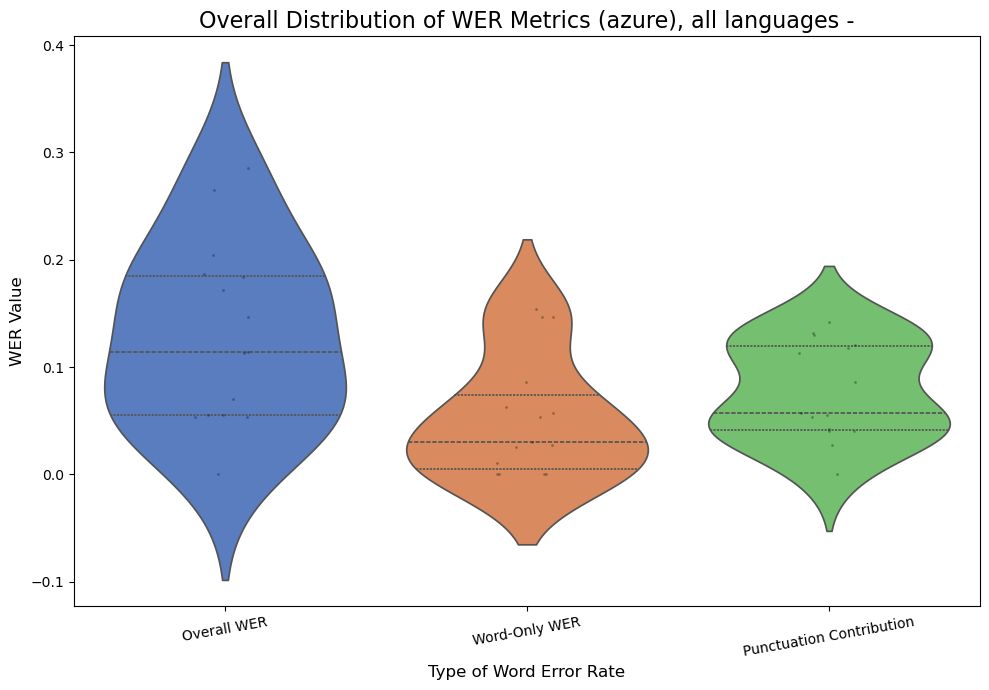

Plot saved as wer_violin_plot_overall_azure.png


In [19]:
plot_overall_wer_distribution(results_df)


--- Generating Per-Language WER Distribution Plots ---


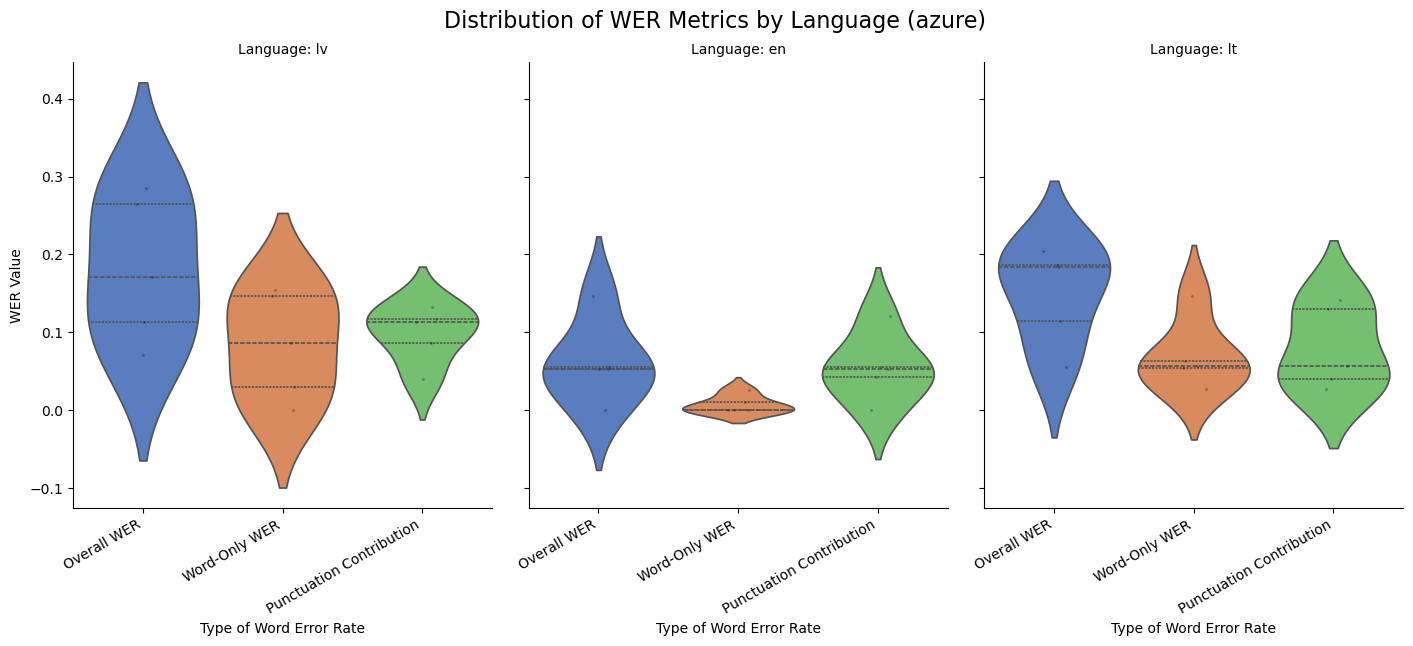

Plot saved as wer_violin_plot_by_language_azure.png


In [20]:
plot_per_language_wer_distributions(results_df)